# <center> R1.04 Méthodes d'optimisation <br> TP1b - Descente de gradient 2D (et plus) </center>
<center> 2023/2024 -Tom Ferragut, Thibault Godin & Lucie Naert </center>
<center> IUT de Vannes, BUT Informatique </center>

Le but de ce TP est d'implémenter quelques méthodes numériques d'optimisation, basées sur les méthodes de gradient, dans un espace $\mathbb{R}^n$ avec $n \geq 2$

In [23]:
import numpy as np


# Affichage graphique

%matplotlib notebook
# enable interactivity of plots
# attention a bien fermer les fenetres plt après chaque visualisation

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

cmap_reversed = matplotlib.colormaps.get_cmap('RdBu_r')


## Échauffement : quelques dessins

La descente de gradient est un algorithme utilisable en toutes dimensions, cependant la partie intuition vient généralement des dimensions 1 et 2. 

On commence donc par quelques fonctions qui seront utiles pour visualiser des fonctions $f : \mathbb{R}^2 \to \mathbb{R}$.

L'exemple développé ici concerne la fonction f ci-dessous : 
$$f(x,y) = \frac{sin(x^2+y^2-x)}{\sqrt{x^2+y^2}+1}$$


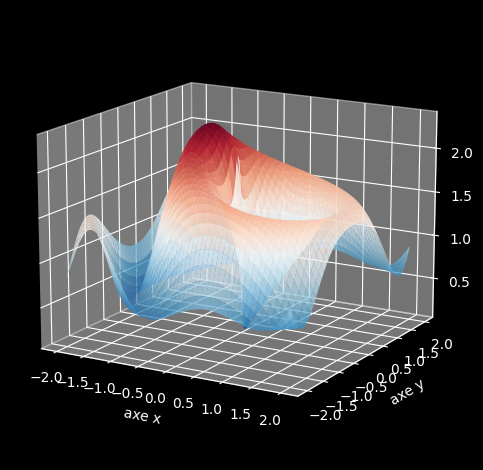

In [24]:
#dessin 2D -> 1D

n = 150


# linspace : "return evenly spaced numbers over a specified interval" 
# (ici : 150 nombres homogènement répartis entre -2 et 2)
VX = np.linspace(-2.0, 2.0, n) 
VY = np.linspace(-2.0, 2.0, n)

# meshgrid : renvoie des matrices de coordonnées qui, combinées, donnent 
# les coordonnées de tous les points constructibles à partir des vecteurs en paramètre
X,Y = np.meshgrid(VX, VY)

# Tester le plot avec un n = 10 au lieu de 150
# plt.plot(X, Y, 'o', color = 'r')

def f(x, y):  
    r = np.sqrt(x**2 + y**2)
    z = np.sin(r**2 - x) / r + 1
    return z


Z = f(X, Y)


fig = plt.figure()
ax = plt.axes(projection = '3d')
# Tweaking display region and labels
# ax.set_xlim(-3.0, 3.0)
# ax.set_ylim(-3.0, 3.0)
# ax.set_zlim(0, 4.0)
ax.set_xlabel('axe x')
ax.set_ylabel('axe y')
ax.set_zlabel('axe z')

# Point de vue en degrés (premier parametre : hauteur, deuxième : angle latéral)
ax.view_init(15, -60)

# surface (alpha : transparence -> 0 completement transparent)
# colormap : bas en bleu, haut en rouge
ax.plot_surface(X, Y, Z, alpha = 0.8, cmap = cmap_reversed)


plt.tight_layout()
# plt.savefig('fonctions-niveau-1d.png')
plt.show()


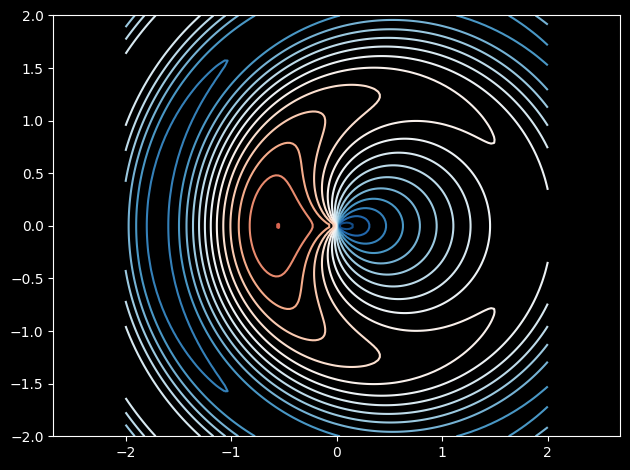

In [25]:
# courbes de niveau
# Contours et surface

# On affiche 20 niveaux différents entre 0 et 3
mes_niveaux = np.linspace(0, 3, 20)

# ligne de niveau dans le plan
fig = plt.figure()
plt.xlim(-2.0, 2.0)
plt.ylim(-2.0, 2.0)
# Plus les lignes sont rapprochées, plus la pente est forte
plt.contour(X, Y, Z, mes_niveaux, cmap = cmap_reversed)
plt.axis('equal') 

plt.tight_layout()
plt.show()


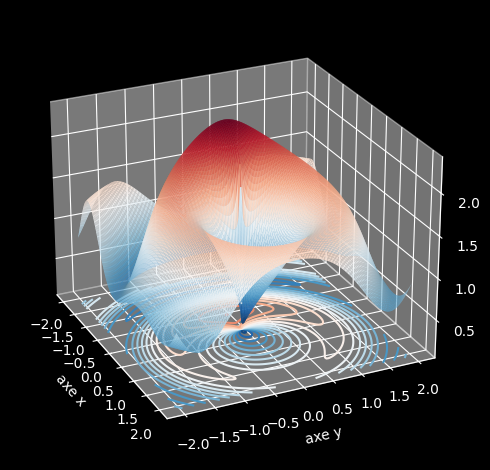

In [26]:
#surface + lignes de niveau

fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.set_xlabel('axe x')
ax.set_ylabel('axe y')
ax.set_zlabel('axe z')
ax.view_init(25, -25)

mes_niveaux = np.linspace(0, 3, 20)
ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1, edgecolor = 'none', alpha = 0.9, cmap = cmap_reversed)
ax.contour(X, Y, Z, mes_niveaux, offset = 0, cmap = cmap_reversed, linestyles = "solid")

#ax.view_init(15, -60)
plt.tight_layout()
plt.show()


# Descente de gradient en deux dimensions


## Exercice 1 : Un exemple à fonction f fixée

Le but de cet exercice est d'implémenter la méthode (la plus basique) de descente de gradient, en 2D.


On va considérer la fonction $f: (x,y) \mapsto (x^2 +y -11)^2 + (x+y^2 -7)^2$


On rappelle l'étape clef du gradient :

$$a_{k+1} = a_k -  \delta \nabla f(a_k)$$



**Question 1**

1. Ecrire le corps de la fonction `f(x,y)`. 
2. Remarquez que l'on peut également la définir comme ne prenant qu'un seul paramètre $X$ définit à une liste de taille 2. Ecrire `f(X)`. Cette deuxième façon est plus facilement généralisable à $n$ dimensions. C'est cette syntaxe que nous privilégierons pour la suite.

In [27]:
def f(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

def f(X):
    return (X[0]**2 + X[1] - 11)**2 + (X[0] + X[1]**2 - 7)**2


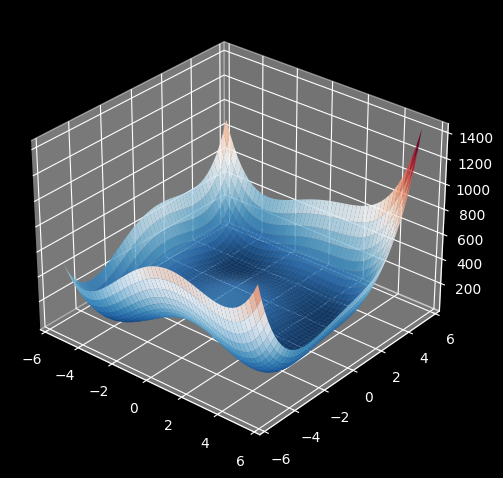

In [28]:
X,Y = np.meshgrid(np.linspace(-5.5, 5.5, 50),
                  np.linspace(-5.5, 5.5, 50))
Z = f([X, Y])  # Utilisation de la version f(X)


fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.view_init(30, -50)
ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1, edgecolor = 'none', alpha = 0.9, cmap = cmap_reversed)

plt.tight_layout()
plt.show()


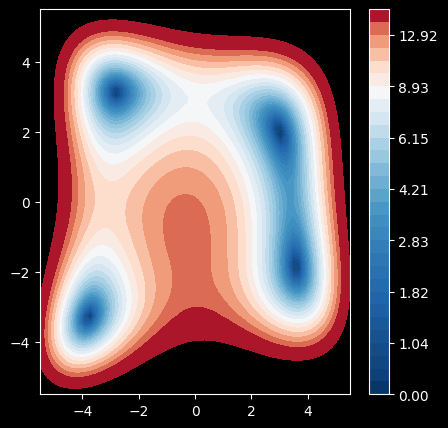

In [29]:
# vue du dessus pour augmenter la lisbilité
# passage à la racine carrée pour les même raisons
X,Y = np.meshgrid(np.linspace(-5.5, 5.5, 50),
                  np.linspace(-5.5, 5.5, 50))
Z = f([X, Y])
levels = list(1.7 ** np.linspace(0, 10, 30) - 1.) + [300]
plt.figure(figsize = (5, 5))
plt.contourf(X, Y, np.sqrt(Z), levels = np.sqrt(levels), cmap = cmap_reversed)
plt.colorbar()
plt.show()


**Question 2**


Calculer théoriquement $\nabla f(x,y) = (\frac{\partial f}{\partial x}(x,y), \frac{\partial f}{\partial y}(x,y))$. L'implémenter dans `f_grad(x,y)`.

La dérivée partielle de \(f\) par rapport à \(x\) est donnée par :

$$
\frac{\partial f}{\partial x} = 2(x^2 + y - 11) \cdot 2x + 2(x + y^2 - 7) \cdot 1 = 4x(x^2 + y - 11) + 2(x + y^2 - 7)
$$

La dérivée partielle de \(f\) par rapport à \(y\) est donnée par :

$$
\frac{\partial f}{\partial y} = 2(x^2 + y - 11) \cdot 1 + 2(x + y^2 - 7) \cdot 2y = 2(x^2 + y - 11) + 4y(y^2 + x - 7)
$$

In [30]:
def f_grad(x, y):
    df_x = 4 * x * (x**2 + y - 11) + 2 * (x + y**2 - 7)
    df_y = 2 * (x**2 + y - 11) + 4 * y * (y**2 + x - 7)
    return np.array([df_x, df_y])


**Question 3**

Écrire une fonction `gradDes2EZ_q3(x0,y0,k,d)` implémentant la descente de gradient pour cet exemple. Cette fonction retourne la liste des points visités lors de la descente de gradient

In [31]:
def gradDes2EZ_q3(x0, y0, k = 10, d = .01):
    """ Descente de gradient pour la fonction x,y ->  (x^2 +y -11)^2 + (x+y^2 -7)^2

    Parameters:
    x0,y0 (float): points initiaux
    k (int): nombre d'itérations
    d (float): pas

    Returns:
    liste_X,liste_Y: points visités lors de la descente de gradient
   """

    liste_X, liste_Y = [x0], [y0]
    
    for _ in range(k):
        grad = f_grad(x0, y0)
        x0 -= d * grad[0]
        y0 -= d * grad[1]
        liste_X.append(x0)
        liste_Y.append(y0)
    
    return [liste_X, liste_Y]

x0, y0 = 0.5, -4 
gradDes2EZ_q3(x0, y0)


[[0.5,
  0.605,
  0.947634695,
  1.4443555419253844,
  2.106590234553037,
  2.845205942971301,
  3.399704929613084,
  3.574879918337229,
  3.5807942734679368,
  3.581636747201382,
  3.582427227331109],
 [-4,
  -2.185,
  -2.070276235,
  -1.9731018871851784,
  -1.886575441219658,
  -1.8182843739706784,
  -1.7855450862166504,
  -1.790428682806361,
  -1.8059343426251486,
  -1.8176569626731067,
  -1.826190140651486]]

**Question 4**

Illustrer l'algorithme en traçant les points visités sur la vue du dessus

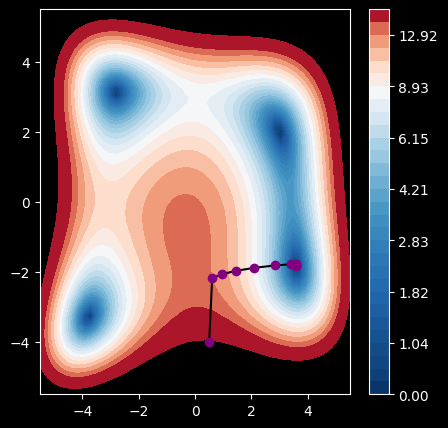

In [32]:
X,Y = np.meshgrid(np.linspace(-5.5, 5.5, 50),np.linspace(-5.5, 5.5, 50))
def graphique_descente_2EZ(x0, y0, k = 10, d = .01):
    
    levels = list(1.7 ** np.linspace(0, 10, 30) - 1.) + [300]
    plt.figure(figsize = (5, 5))
    plt.contourf(X, Y, np.sqrt(Z), levels = np.sqrt(levels), cmap = cmap_reversed)
    plt.colorbar()
    xs = gradDes2EZ_q3(x0, y0, k, d)
    x, y = np.array(xs)
    plt.plot(x, y, 'k')
    plt.plot(x, y, 'o', color = 'purple')
    plt.show()
    
x0, y0 = 0.5, -4 

graphique_descente_2EZ(x0, y0)


**Question 5**

Faire varier les paramètres à l'aide de widgets. Que remarquez-vous ?

> Faire varier x0 et y0 permet de changer le point de départ de la descente de gradient. Faire varier k permet de changer le nombre d'itérations de la descente de gradient. Faire varier d permet de changer le pas de la descente de gradient.

In [33]:
from ipywidgets import interact, fixed

interact(graphique_descente_2EZ, x0 = (-5, 5, 0.1), y0 = (-5, 5, 0.1), k = (1, 100, 1), d = (0.01, 0.1, 0.01))


interactive(children=(FloatSlider(value=0.0, description='x0', max=5.0, min=-5.0), FloatSlider(value=0.0, desc…

<function __main__.graphique_descente_2EZ(x0, y0, k=10, d=0.01)>

**Question 6** Une méthode d'arret classique est de stopper si on a atteint le nombre maximal d'itérations autorisé, ou bien que le gradient est suffisamment proche de zéro (typiquement $|\nabla f | < 10^{-5}$ i.e. la somme des deux dérivées partielles est inférieure à $ \varepsilon = 10^{-5}$). 

Implémenter ce critère dans `gradDes2EZ_q6`. Faites en sorte d'afficher le nombre de pas executés.

In [34]:
def gradDes2EZ_q6(x0, y0, k = 10, d = .01, eps = 1e-5):
    liste_X, liste_Y = [x0], [y0]
    for i in range(k):
        grad = f_grad(x0, y0)
        if np.linalg.norm(grad) < eps:
            print(f"Arrêt après {i} itérations")
            break
        x0 -= d * grad[0]
        y0 -= d * grad[1]
        liste_X.append(x0)
        liste_Y.append(y0)
    else:
        print(f"Nombre maximal d'itérations atteint : {k}")
    return [liste_X, liste_Y]

# Exemple d'utilisation
x0, y0 = 0.5, -4
z = gradDes2EZ_q6(x0, y0, 100)


Arrêt après 43 itérations


## Exercice 2 : Algorithme générique ($\mathbb{R}^2 \to \mathbb{R}$)


On va maintenant implémenter un version plus générique :

<tt>gradDes2(f,X0,f_grad=f_gradapprox(f),k=10,d=.01) </tt>


avec 

- $f :\mathbb{R}^2 \to \mathbb{R} $ une fonction quelconque.
- $X_0 \in \mathbb{R}^2$ un vecteur d'initialisation
- <tt>f_grad</tt> une fonction $\mathbb{R}^2 \to \mathbb{R} $ faisant office de gradient pour $f$ (par défaut, si on ne sait pas calculer le gradient on renvoie une approximation définie par <tt>f_gradapprox</tt> qui utilise :
$\nabla f(x)  \approx (\frac{f(x+\varepsilon,y)-f(x-\varepsilon,y)}{2\varepsilon},\frac{f(x,y+\varepsilon)-f(x,y-\varepsilon)}{2\varepsilon})$
- $k$ le nombre maximum d'itération
- $d$ le pas (supposé constant)

**Question 1** 

Ecrire la fonction `f_gradapprox` qui calcule une approximation de $\nabla f(x)$ et `gradDes2` qui fait la descente de gradient sur n'importe quelle fonction f.

In [35]:
def f(X): # from matlab website
    x, y = X  
    z = 3 * (x - 1)**2 * np.exp(-(y + 1)**2 - x**2) - 1 / 3 * (np.exp(-(x + 1)**2 - x**2)) + (10 * x**3 - 2 * x + 10 * y **5) * np.exp(-x**2 - y**2)
    return z


def f_gradapprox(f, X, eps = 1.e-5):
    x, y = X
    grad_x = (f([x + eps, y]) - f([x - eps, y])) / (2 * eps)
    grad_y = (f([x, y + eps]) - f([x, y - eps])) / (2 * eps)
    return np.array([grad_x, grad_y])


def gradDes2(f, X0, f_grad = None, k = 10, d = .01, verbatim = False):
    X = X0
    if f_grad is None:
        f_grad = lambda X: f_gradapprox(f, X)
    for i in range(k):
        grad = f_grad(X)
        X = X - d * grad
        if verbatim:
            print(f"Iteration {i + 1}, X = {X}")
    return X


eps = 1e-5
gradDes2(f, np.array([0, 0]), verbatim = True)


Iteration 1, X = [0.03962024 0.02207277]
Iteration 2, X = [0.07762074 0.04190624]
Iteration 3, X = [0.11295109 0.0596331 ]
Iteration 4, X = [0.14486392 0.07544909]
Iteration 5, X = [0.17296778 0.08958672]
Iteration 6, X = [0.19719628 0.1022878 ]
Iteration 7, X = [0.2177266  0.11378171]
Iteration 8, X = [0.23488622 0.1242721 ]
Iteration 9, X = [0.24907321 0.13393155]
Iteration 10, X = [0.2606997  0.14290163]


array([0.2606997 , 0.14290163])

**Question 2** 

Illustrer cet algorithme en écrivant la méthode `graphique_descente_2`

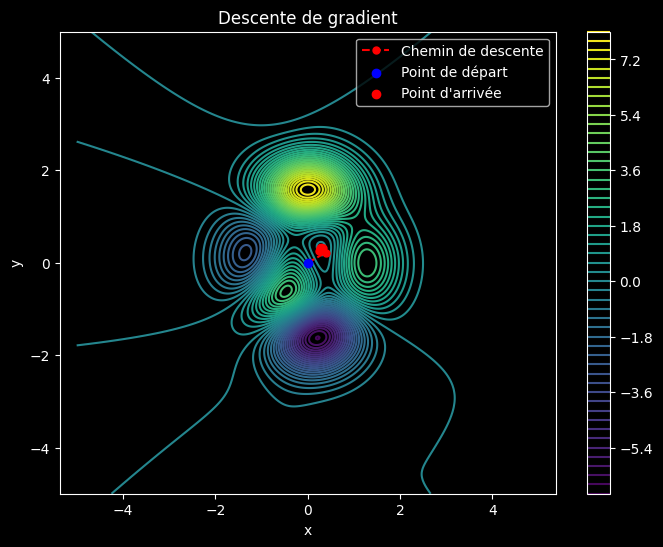

In [36]:
def graphique_descente_2(f, X0, f_grad = None, k = 10, d = .1, verbatim = False):
    points = [X0]
    X = X0
    if f_grad is None:
        f_grad = lambda X: f_gradapprox(f, X)
    for i in range(k):
        grad = f_grad(X)
        X = X - d * grad
        points.append(X)
        if verbatim:
            print(f"Iteration {i + 1}, X = {X}")
    
    points = np.array(points)
    
    x_range = np.linspace(X0[0] - 5, X0[0] + 5, 400)
    y_range = np.linspace(X0[1] - 5, X0[1] + 5, 400)
    X, Y = np.meshgrid(x_range, y_range)
    Z = f([X, Y])
    
    plt.figure(figsize = (8, 6))
    plt.contour(X, Y, Z, levels = 50, cmap = 'viridis')
    plt.colorbar()
    plt.plot(points[:, 0], points[:, 1], 'r--', marker = 'o', markersize = 5, label = 'Chemin de descente')
    plt.scatter(points[0, 0], points[0, 1], color = 'blue', zorder = 5, label = 'Point de départ')
    plt.scatter(points[-1, 0], points[-1, 1], color = 'red', zorder = 5, label = 'Point d\'arrivée')
    plt.title('Descente de gradient')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.axis('equal')
    plt.show()

    
graphique_descente_2(f,np.array([0,0]))


**Question 3** Observer l'effet de la modification des paramètres.

> L'utilisation de interact avec les paramètres `k` (nombre d'itérations) et `d` (pas de la descente) permet d'observer dynamiquement comment la convergence de l'algorithme de descente de gradient est affectée par ces deux paramètres. Augmenter `k` permet plus d'itérations et donc potentiellement une meilleure approximation du minimum, tandis que varier `d` modifie la taille des "pas" à chaque itération, influençant directement la rapidité de la convergence ou le risque de "sauter" au-delà du minimum.

In [37]:
interact(graphique_descente_2,f=fixed(f), X0=fixed([0,0]),f_grad=fixed(lambda x : f_gradapprox(f,x)), k=(0, 50, 1), d=(0., .5, 0.005))


interactive(children=(IntSlider(value=10, description='k', max=50), FloatSlider(value=0.1, description='d', ma…

<function __main__.graphique_descente_2(f, X0, f_grad=None, k=10, d=0.1, verbatim=False)>

**Question 4** Que se passe-il si on applique la méthode du gradient à la fonction $(x,y) \mapsto -x^2 -y^2$ ?

Pour la fonction $f(x,y) \mapsto -x^2 -y^2$, le gradient pointera toujours vers l'origine, mais étant donné que cette fonction est concave partout, la descente de gradient va s'éloigner de l'origine, ce qui est l'opposé de ce que l'on recherche habituellement (un minimum). Visualiser cette descente, surtout en 3D, peut aider à comprendre comment l'algorithme "cherche" le point le plus bas dans le cas de cette fonction, qui est en réalité un maximum global.

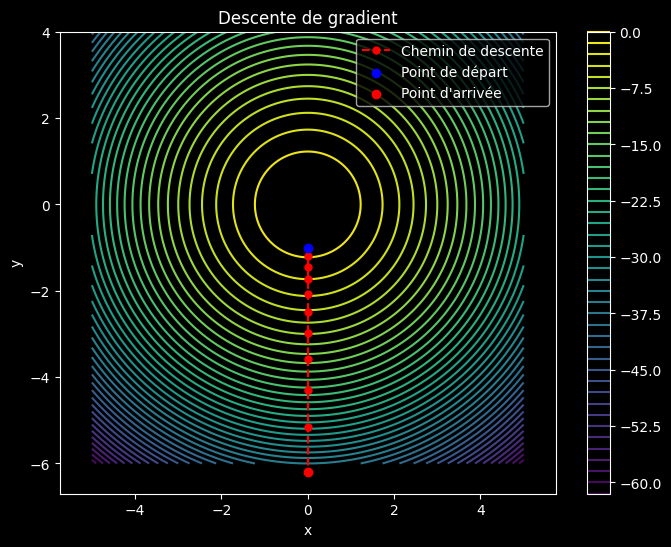

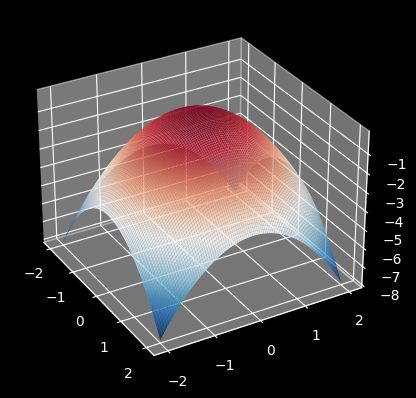

In [38]:
def f(X):
    return -X[0]**2 - X[1]**2
graphique_descente_2(f, np.array([0, -1]))

########### Vue 3D ###########
n = 100
VX = np.linspace(-2.0, 2.0, n)
VY = np.linspace(-2.0, 2.0, n)
X, Y = np.meshgrid(VX, VY)


Z = f([X, Y])

fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.view_init(30, -30)
ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1, edgecolor = 'none', alpha = 0.9, cmap = cmap_reversed)


plt.show()


**Question 5** La méthode du gradient n'est pas garantie de converger. Un précaution supplémentaire consiste à ajouter un critère de sortie si le gradient commence à exploser, par exemple en dépassant $10 000$ fois la norme du gradient d'origine. Rajouter cette précaution en définissant `gradDes2_q5`. Afficher le nombre de pas avant l'arrêt de l'algorithme.

In [39]:
def gradDes2_q5(f, X0, f_grad = None, k = 10, d = .01, eps = 1e-5, verbatim = False):
    if f_grad is None:
        f_grad = lambda X: f_gradapprox(f, X)
    X = X0
    grad_origin_norm = np.linalg.norm(f_grad(X))
    for i in range(k):
        grad = f_grad(X)
        if np.linalg.norm(grad) > 10000 * grad_origin_norm:
            print(f"Arrêt dû à l'explosion du gradient après {i + 1} itérations")
            break
        X = X - d * grad
        if verbatim:
            print(f"Iteration {i + 1}, X = {X}")
    return X

def f(X):
    x, y = X  
    z = -x**2 - y**2
    return z

eps = 1e-5
gradDes2_q5(f, np.array([0, -1]), k = 100, d = 0.2, verbatim = True)


Iteration 1, X = [ 0.  -1.4]
Iteration 2, X = [ 0.   -1.96]
Iteration 3, X = [ 0.    -2.744]
Iteration 4, X = [ 0.     -3.8416]
Iteration 5, X = [ 0.      -5.37824]
Iteration 6, X = [ 0.       -7.529536]
Iteration 7, X = [  0.        -10.5413504]
Iteration 8, X = [  0.         -14.75789056]
Iteration 9, X = [  0.         -20.66104678]
Iteration 10, X = [  0.        -28.9254655]
Iteration 11, X = [  0.        -40.4956517]
Iteration 12, X = [  0.         -56.69391238]
Iteration 13, X = [  0.         -79.37147734]
Iteration 14, X = [   0.         -111.12006829]
Iteration 15, X = [   0.         -155.56809562]
Iteration 16, X = [   0.         -217.79533388]
Iteration 17, X = [   0.         -304.91346748]
Iteration 18, X = [   0.         -426.87885412]
Iteration 19, X = [   0.         -597.63039528]
Iteration 20, X = [   0.         -836.68255313]
Iteration 21, X = [    0.         -1171.35557295]
Iteration 22, X = [    0.         -1639.89780187]
Iteration 23, X = [    0.         -2295.8569200

array([     0.        , -12347.66935646])